In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

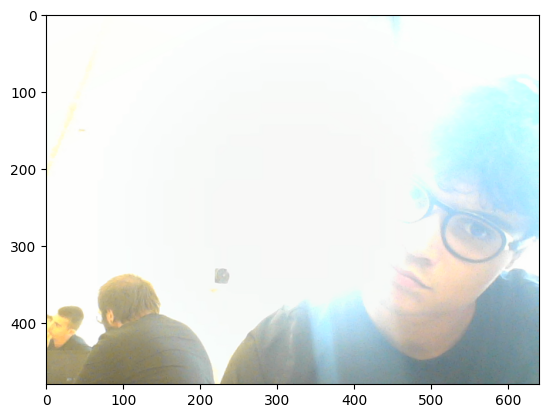

In [7]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(image)

cap.release()